In [19]:
# %%
# Required imports
import pandas as pd
from openai import OpenAI
from langgraph.graph import StateGraph, START, END
from datetime import datetime
from typing import Dict, List, Any, Optional, TypedDict
from concurrent.futures import ThreadPoolExecutor
import numpy as np
import os
import random
import re


In [ ]:
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")

In [21]:
# Define file paths for the CERT dataset
logon_file = "r4.1/logon.csv"
file_access_file = "r4.1/file.csv"
email_file = "r4.1/email.csv"
device_file = "r4.1/device.csv"
http_file = "r4.1/http.csv"
psychometric_file = "r4.1/psychometric.csv"
ground_truth_file = "answers/r4.1-1.csv"

# Load dataset
logon_df = pd.read_csv(logon_file)
file_access_df = pd.read_csv(file_access_file)
email_df = pd.read_csv(email_file)
device_df = pd.read_csv(device_file)
http_df = pd.read_csv(http_file)
psychometric_df = pd.read_csv(psychometric_file)
ground_truth_df = pd.read_csv(ground_truth_file, names=["log_type", "id", "date", "user", "pc", "activity_or_url", "content"], header=None)

# Define the CERT data dictionary
data_dict = {
    'logon': logon_df,
    'file_access': file_access_df,
    'email': email_df,
    'device': device_df,
    'http': http_df
}

In [23]:
import numpy as np
import random
import re
from typing import List, Dict
from scipy.stats import dirichlet

class UncertaintyAwareRLToolBuilderAgent:
    def __init__(self, api_key, learning_rate=0.1, discount_factor=0.9, exploration_rate=0.1, max_retries=10, num_actions=3):
        self.client = OpenAI(api_key=api_key)
        self.tools = {}
        self.q_table = {}
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.exploration_rate = exploration_rate
        self.max_retries = max_retries
        self.num_actions = num_actions  # Number of available actions
        self.uncertainties = {"vacuity": [], "dissonance": [], "entropy": []}

    def choose_action(self, state):
        action_probabilities = self.get_action_probabilities(state)
        action = np.random.choice(range(self.num_actions), p=action_probabilities)
        print(f"Chosen action with probabilities {action_probabilities}: {action}")
        return action

    def get_action_probabilities(self, state):
        action_counts = [self.q_table.get(state, {}).get(a, 0) + 1 for a in range(self.num_actions)]
        dirichlet_params = [count / sum(action_counts) for count in action_counts]
        probabilities = dirichlet.rvs(dirichlet_params).flatten()
        return probabilities

    def update_uncertainty_measures(self, action_probabilities):
        vacuity = 1 - sum(action_probabilities) / self.num_actions
        dissonance = sum([abs(a_i - a_j) for a_i in action_probabilities for a_j in action_probabilities if a_i != a_j]) / 2
        entropy = -sum(p * np.log2(p) if p > 0 else 0 for p in action_probabilities) / np.log2(self.num_actions)
        
        self.uncertainties["vacuity"].append(vacuity)
        self.uncertainties["dissonance"].append(dissonance)
        self.uncertainties["entropy"].append(entropy)
        print(f"Updated uncertainty measures: Vacuity={vacuity}, Dissonance={dissonance}, Entropy={entropy}")

    def generate_tool_code(self, task_name, requirements, prompt_style, columns):
        prompt_templates = {
            "default_prompt": f"Generate a complete, well-formatted Python function named '{task_name}' to detect {requirements}. Ensure column names ({', '.join(columns)}) are validated, with detailed error handling.",
            "verbose_prompt": f"Create a Python function '{task_name}' for {requirements}. Ensure columns ({', '.join(columns)}) are checked and formatted correctly.",
            "specific_prompt": f"Generate a Python function '{task_name}', optimized for pandas, to handle {requirements}. Verify columns ({', '.join(columns)}) and handle errors."
        }

        prompt = prompt_templates.get(prompt_style, prompt_templates["default_prompt"])
        
        for attempt in range(self.max_retries):
            response = self.client.chat.completions.create(
                model="gpt-4",
                messages=[{"role": "user", "content": prompt}],
                max_tokens=2000
            )
            raw_text = response.choices[0].message.content.strip()
            code = self.extract_code(raw_text)
            if code and self.is_code_valid(code):
                print(f"Generated code after {attempt + 1} attempt(s)")
                return code
            else:
                print(f"Retry {attempt + 1}/{self.max_retries}: Syntax issue, retrying...")
        return None

    def extract_code(self, response_text):
        code_match = re.search(r"```python\n(.*?)\n```", response_text, re.DOTALL)
        return code_match.group(1) if code_match else response_text

    def is_code_valid(self, code):
        try:
            compile(code, "<string>", "exec")
            return True
        except SyntaxError as e:
            print(f"Syntax issue: {e}")
            return False

    def evaluate_tool(self, tool_name):
        tool_func = self.tools.get(tool_name)
        if tool_func:
            test_data = self._get_test_data(tool_name)
            try:
                result = tool_func(test_data)
                return 10 if isinstance(result, pd.DataFrame) and not result.empty else -5
            except Exception as e:
                print(f"Error during evaluation: {e}")
                return -5
        return -10

    def create_tool(self, task_name, requirements, columns):
        state = task_name
        action = self.choose_action(state)

        tool_code = self.generate_tool_code(task_name, requirements, action, columns)
        if tool_code is None:
            print(f"Code generation failed for {task_name} after maximum retries.")
            self.update_q_table(state, action, -10)
            return

        try:
            exec(tool_code, globals())
            func_name = task_name.replace(' ', '_')
            self.tools[task_name] = globals().get(func_name)
            reward = self.evaluate_tool(func_name)
            self.update_q_table(state, action, reward)
        except Exception as e:
            print(f"Tool generation failed for {task_name}: {e}")
            self.update_q_table(state, action, -10)

    def update_q_table(self, state, action, reward):
        current_q = self.q_table.get(state, {}).get(action, 0)
        best_future_q = max(self.q_table.get(state, {}).values(), default=0)
        new_q = current_q + self.learning_rate * (reward + self.discount_factor * best_future_q - current_q)
        self.q_table.setdefault(state, {})[action] = new_q
        print(f"Q-table updated: State={state}, Action={action}, Q-value={new_q}")


In [24]:
# Initialize the RL agent
rl_agent = UncertaintyAwareRLToolBuilderAgent(api_key=OPENAI_API_KEY)

# Provide necessary columns and create tools
rl_agent.create_tool("logon", "Detect after-hours logins", columns=["user", "activity", "date"])
rl_agent.create_tool("file_access", "Detect access to sensitive files", columns=["filename", "user", "access_type"])
rl_agent.create_tool("email", "Identify emails with confidential content", columns=["content", "user"])
rl_agent.create_tool("device", "Detect abnormal device usage patterns", columns=["device_id", "user", "timestamp"])
rl_agent.create_tool("http", "Identify visits to suspicious websites", columns=["url", "user", "content"])


Chosen action with probabilities [0.01044916 0.00471269 0.98483815]: 2
Generated code after 1 attempt(s)
Tool generation failed for logon: 'UncertaintyAwareRLToolBuilderAgent' object has no attribute '_get_test_data'
Q-table updated: State=logon, Action=2, Q-value=-1.0
Chosen action with probabilities [0.32054306 0.61995145 0.05950549]: 0
Generated code after 1 attempt(s)
Tool generation failed for file_access: 'UncertaintyAwareRLToolBuilderAgent' object has no attribute '_get_test_data'
Q-table updated: State=file_access, Action=0, Q-value=-1.0
Chosen action with probabilities [3.97861171e-03 9.96021255e-01 1.32941384e-07]: 1
Generated code after 1 attempt(s)
Tool generation failed for email: 'UncertaintyAwareRLToolBuilderAgent' object has no attribute '_get_test_data'
Q-table updated: State=email, Action=1, Q-value=-1.0
Chosen action with probabilities [5.19474033e-04 2.74298750e-02 9.72050651e-01]: 2
Generated code after 1 attempt(s)
Tool generation failed for device: 'UncertaintyAw

In [25]:
# Define CERT dataset dictionaries
data_dict = {
    'logon': logon_df,
    'file_access': file_access_df,
    'email': email_df,
    'device': device_df,
    'http': http_df,
    'psychometric': psychometric_df
}

# Define each agent for processing different data types
class LogonAgent:
    def detect(self, logon_df):
        return logon_df[(logon_df['activity'] == 'Logon') & ((logon_df['hour'] < 9) | (logon_df['hour'] > 17))]

class FileAccessAgent:
    def detect(self, file_df):
        return file_df[file_df['filename'].str.contains('confidential|sensitive', case=False, na=False)]

class EmailAgent:
    def __init__(self, rl_agent):
        self.rl_agent = rl_agent
    
    def detect(self, email_df):
        suspicious_email_func = self.rl_agent.tools.get('detect_suspicious_email_content')
        if suspicious_email_func:
            return suspicious_email_func(email_df)
        return pd.DataFrame()

class DeviceAgent:
    def detect(self, device_df):
        device_counts = device_df.groupby('user').size()
        threshold = device_counts.mean() + 2 * device_counts.std()
        return device_counts[device_counts > threshold]

class HTTPAgent:
    def detect(self, http_df):
        return http_df[http_df['url'].str.contains('risky|malware|untrusted', case=False, na=False)]

class PsychometricAgent:
    def __init__(self, psychometric_df):
        self.psychometric_df = psychometric_df
    
    def adjust_threshold(self, user_id):
        profile = self.psychometric_df[self.psychometric_df['user_id'] == user_id]
        return profile.iloc[0] if not profile.empty else None


# Define validation node
class ValidationAgent:
    def __init__(self, ground_truth_df):
        self.ground_truth_df = ground_truth_df

    def validate_anomalies(self, detected_anomalies):
        validated = pd.merge(detected_anomalies, self.ground_truth_df, on=['user', 'date'], how='inner')
        precision = len(validated) / len(detected_anomalies) if len(detected_anomalies) > 0 else 0
        recall = len(validated) / len(self.ground_truth_df) if len(self.ground_truth_df) > 0 else 0
        return precision, recall

def validation_node(state):
    validation_agent = ValidationAgent(state['ground_truth_df'])
    precision, recall = validation_agent.validate_anomalies(pd.concat(state['anomalies'].values()))
    state['validation_metrics'] = {
        "precision": precision,
        "recall": recall
    }
    return state

In [26]:
# Define anomaly aggregator node
def anomaly_aggregator_node(state):
    # Aggregate anomalies from all tasks
    anomaly_frames = [state['anomalies'].get(task) for task in state['anomalies'] if state['anomalies'][task] is not None]
    aggregated_anomalies = pd.concat(anomaly_frames, keys=state['anomalies'].keys())
    state['final_summary'] = aggregated_anomalies.groupby('user').size().to_dict()
    return state

def validation_node(state):
    validation_agent = ValidationAgent(state['ground_truth_df'])
    precision, recall = validation_agent.validate_anomalies(pd.concat(state['anomalies'].values()))
    state['validation_metrics'] = {
        "precision": precision,
        "recall": recall
    }
    return state

# Define nodes for each agent to run in parallel
def logon_node(state):
    agent = LogonAgent()
    state['anomalies']['logon'] = agent.detect(state['data_dict']['logon'])
    return state

def file_access_node(state):
    agent = FileAccessAgent()
    state['anomalies']['file_access'] = agent.detect(state['data_dict']['file_access'])
    return state

def email_node(state):
    agent = EmailAgent(rl_agent)
    state['anomalies']['email'] = agent.detect(state['data_dict']['email'])
    return state

def device_node(state):
    agent = DeviceAgent()
    state['anomalies']['device'] = agent.detect(state['data_dict']['device'])
    return state

def http_node(state):
    agent = HTTPAgent()
    state['anomalies']['http'] = agent.detect(state['data_dict']['http'])
    return state

def psychometric_node(state):
    agent = PsychometricAgent(state['data_dict']['psychometric'])
    for user_id in state['anomalies']:
        state['anomaly_thresholds'][user_id] = agent.adjust_threshold(user_id)
    return state

In [ ]:
class DecomposerAgent:
    def decompose_tasks(self, data_dict):
        # Decompose data_dict into separate tasks based on data type
        return {log_type: df for log_type, df in data_dict.items()}

class ExecutorAgent:
    def __init__(self, tool_builder, behavioral_context_agent):
        self.tool_builder = tool_builder
        self.context_agent = behavioral_context_agent

    def execute_task(self, task_type, logs):
        anomalies = []
        tool = self.tool_builder.tools.get(task_type)
        if tool:
            anomalies = tool(logs)
        return anomalies
    

class AnomalyAggregatorAgent:
    def __init__(self, api_key):
        self.client = OpenAI(api_key=api_key)

    def aggregate_anomalies(self, anomaly_dict):
        potential_threats = pd.concat(anomaly_dict.values(), keys=anomaly_dict.keys())
        threat_users = potential_threats.groupby('user').size()
        high_risk_users = threat_users[threat_users > 1]
        response = self.client.Completion.create(
            model="gpt-4",
            messages=[
                {"role": "system", "content": "You are an AI security assistant."},
                {"role": "user", "content": f"Analyze these anomalies and provide a risk assessment:\n\n{high_risk_users.to_dict()}"}
            ],
            max_tokens=50
        )
        return response.choices[0].text.strip()

class ValidationAgent:
    def __init__(self, api_key, ground_truth_df):
        self.client = OpenAI(api_key=api_key)
        self.ground_truth_df = ground_truth_df

    def validate_anomalies(self, detected_anomalies):
        validated = pd.merge(detected_anomalies, self.ground_truth_df, on=['user', 'date'], how='inner')
        precision = len(validated) / len(detected_anomalies) if len(detected_anomalies) > 0 else 0
        recall = len(validated) / len(self.ground_truth_df) if len(self.ground_truth_df) > 0 else 0
        return {"precision": precision, "recall": recall}

In [ ]:
from typing import Optional, Dict, List, Any
import pandas as pd

# Define the schema for the state structure using TypedDict
class WorkflowState(TypedDict):
    data_dict: Dict[str, pd.DataFrame]
    tasks: Dict[str, pd.DataFrame]
    anomalies: Dict[str, pd.DataFrame]
    api_key: str
    ground_truth_df: pd.DataFrame
    final_summary: Optional[Dict[str, int]]
    validation_metrics: Optional[Dict[str, float]]
    tool_builder: Optional[Any]
    context_agent: Optional[Any]

# Initialize the workflow graph with the state schema
workflow = StateGraph(state_schema=WorkflowState)

# Define helper function for task-specific executor nodes
def executor_node_for_task(state: WorkflowState, task_type: str):
    executor = ExecutorAgent(tool_builder=state['tool_builder'], behavioral_context_agent=state.get('context_agent'))
    state['anomalies'][task_type] = executor.execute_task(task_type, state['tasks'][task_type])
    return state

# Define the Decomposer node
def decomposer_node(state: WorkflowState):
    decomposer = DecomposerAgent()
    state['tasks'] = decomposer.decompose_tasks(state['data_dict'])
    return state

# Define the RL Tool Builder node
def rl_tool_builder_node(state: WorkflowState):
    # Initialize the RLToolBuilderAgent with the API key
    tool_builder = UncertaintyAwareRLToolBuilderAgent(api_key=state['api_key'])
    
    # Create tools for each task
    for task_name, task_data in state['tasks'].items():
        # Extract column names from task_data (assuming task_data is a DataFrame)
        columns = list(task_data.columns)
        
        # Create the tool for each task with the required parameters
        tool_builder.create_tool(
            task_name, 
            f"Tool for detecting anomalies in {task_name} data", 
            columns=columns
        )
    
    # Update the state with the tool builder instance
    state['tool_builder'] = tool_builder
    return state


# Define the Executor node
def executor_node(state: WorkflowState):
    executor = ExecutorAgent(tool_builder=state['tool_builder'], behavioral_context_agent=state.get('context_agent'))
    anomalies = {}
    # Execute each task using the tools built by RLToolBuilderAgent
    for task_type, df in state['tasks'].items():
        anomalies[task_type] = executor.execute_task(task_type, df)
    state['anomalies'] = anomalies
    return state

# Define individual anomaly aggregator node
def anomaly_aggregator_node(state: WorkflowState):
    aggregator = AnomalyAggregatorAgent(api_key=state['api_key'])
    state['final_summary'] = aggregator.aggregate_anomalies(state['anomalies'])
    return state

# Define the Validation node
def validation_node(state: WorkflowState):
    validation_agent = ValidationAgent(api_key=state['api_key'], ground_truth_df=state['ground_truth_df'])
    validation_metrics = validation_agent.validate_anomalies(pd.concat(state['anomalies'].values()))
    state['validation_metrics'] = validation_metrics
    return state

# Add nodes to the workflow
workflow.add_node("decomposer_node", decomposer_node)
workflow.add_node("rl_tool_builder_node", rl_tool_builder_node)
workflow.add_node("executor_node", executor_node)

# Parallel nodes for each task type
workflow.add_node("logon_node", lambda state: executor_node_for_task(state, "logon"))
workflow.add_node("file_access_node", lambda state: executor_node_for_task(state, "file_access"))
workflow.add_node("email_node", lambda state: executor_node_for_task(state, "email"))
workflow.add_node("device_node", lambda state: executor_node_for_task(state, "device"))
workflow.add_node("http_node", lambda state: executor_node_for_task(state, "http"))

# Aggregator and validation nodes
workflow.add_node("anomaly_aggregator_node", anomaly_aggregator_node)
workflow.add_node("validation_node", validation_node)

# Define edges for workflow execution
workflow.add_edge(START, "decomposer_node")
workflow.add_edge("decomposer_node", "rl_tool_builder_node")
workflow.add_edge("rl_tool_builder_node", "executor_node")

# Define parallel execution paths for each task
workflow.add_edge("executor_node", "logon_node")
workflow.add_edge("executor_node", "file_access_node")
workflow.add_edge("executor_node", "email_node")
workflow.add_edge("executor_node", "device_node")
workflow.add_edge("executor_node", "http_node")

# Merge results after parallel execution
workflow.add_edge("logon_node", "anomaly_aggregator_node")
workflow.add_edge("file_access_node", "anomaly_aggregator_node")
workflow.add_edge("email_node", "anomaly_aggregator_node")
workflow.add_edge("device_node", "anomaly_aggregator_node")
workflow.add_edge("http_node", "anomaly_aggregator_node")

# Final steps to aggregate and validate anomalies
workflow.add_edge("anomaly_aggregator_node", "validation_node")
workflow.add_edge("validation_node", END)




# Compile and invoke the workflow
compiled_workflow = workflow.compile()


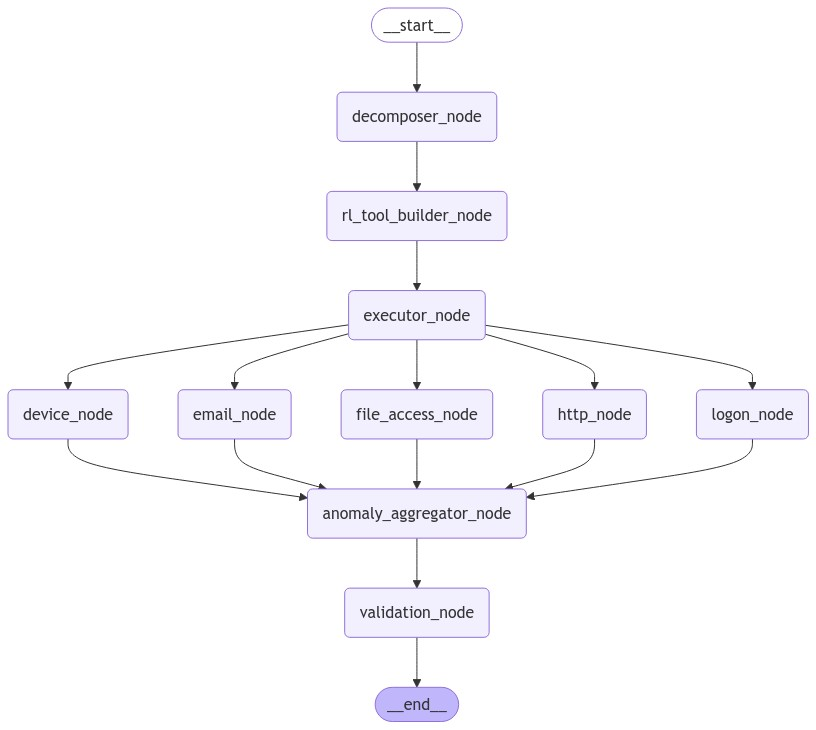

In [29]:
from IPython.display import Image, display


try:
    display(Image(compiled_workflow.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional

    pass

In [ ]:
initial_state = WorkflowState(
    data_dict={
        'logon': logon_df,  # Your logon DataFrame
        'file_access': file_access_df,
        'email': email_df,
        'device': device_df,
        'http': http_df
    },
    tasks={},
    anomalies={},
    api_key=OPENAI_API_KEY,
    ground_truth_df=ground_truth_df,  # Your ground truth DataFrame
    final_summary=None,
    validation_metrics=None,
    tool_builder=None,
    context_agent=None
)
# result_state = compiled_workflow.invoke(initial_state)

# # Display final results
# print("Final Summary of High-Risk Users:", result_state['final_summary'])
# print("Validation Metrics:", result_state['validation_metrics'])